In [5]:
pip install psycopg pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.9/197.9 kB 2.6 MB/s eta 0:00:00 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import psycopg as pg
import numpy as np

# Connect to PostgreSQL database using psycopg3
connection = pg.connect(
    host="localhost",  # or your database host
    port="5432",
    dbname="aisanalysis",
    user="postgres",
    password="your_pass"  # Replace with your actual password
)

# Query to generate the binary bitmap directly from the database
query = """
WITH time_intervals AS (
    -- Generate a series of 10-minute intervals for the entire day
    SELECT generate_series(
        '2024-03-01 00:00:00'::timestamp,
        '2024-03-01 23:59:59'::timestamp,
        '10 minute'::interval
    ) AS time_bin
),
observations AS (
    -- Get distinct MMSI and corresponding observation times
    SELECT MMSI, date_bin('10 minutes', T, TIMESTAMP '2024-03-01 00:00:00'::timestamp) AS observation_bin
    FROM AISInputTarget
    WHERE T >= '2024-03-01 00:00:00' AND T <= '2024-03-01 23:59:59'
)
-- Create the matrix where each cell represents whether an observation exists (0) or is empty (1)
SELECT mmsi_ids.MMSI, time_intervals.time_bin,
    COUNT(observations.observation_bin) > 0 AS has_observations
FROM
    (SELECT DISTINCT MMSI FROM AISInput) AS mmsi_ids
    CROSS JOIN time_intervals
    LEFT JOIN observations ON mmsi_ids.MMSI = observations.MMSI AND time_intervals.time_bin = observations.observation_bin
GROUP BY mmsi_ids.
MMSI, time_intervals.time_bin;
"""

# Load the data into a pandas DataFrame
df = pd.read_sql_query(query, connection)

# Close the connection
connection.close()

/tmp/ipykernel_191433/2611251391.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


/tmp/ipykernel_191433/414527670.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn', 2)  # Red-Yellow-Green colormap, reduced to two colors: Green for data, Red for no-data


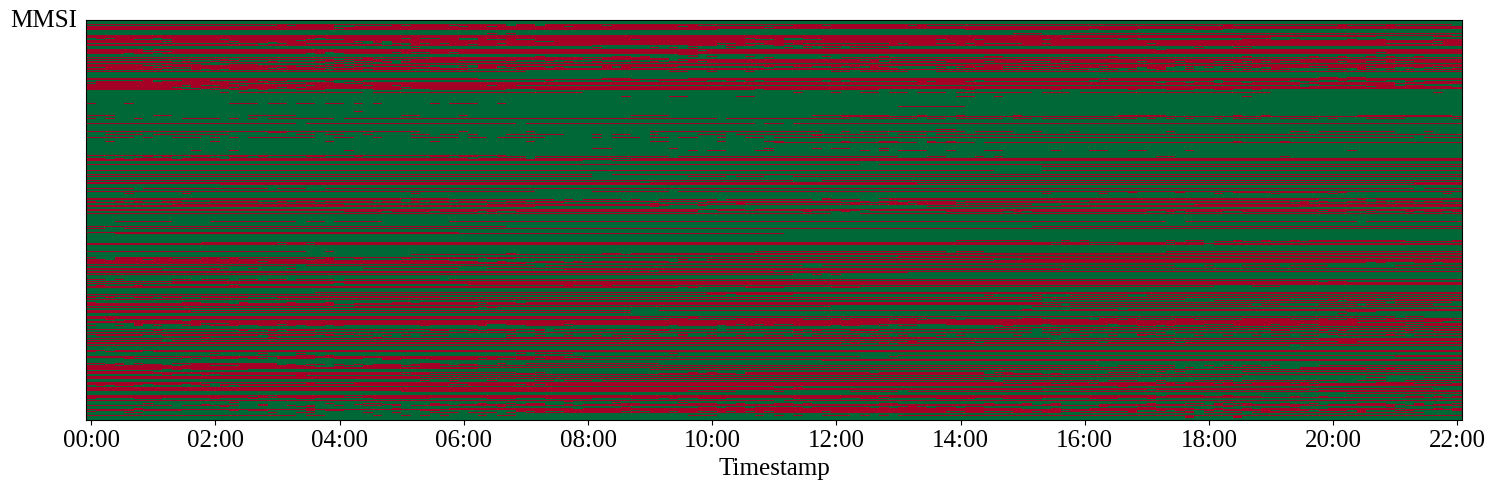

In [30]:

# Pivot the DataFrame to create a matrix for visualization
pivot_df = df.pivot(index='mmsi', columns='time_bin', values='has_observations')

# Convert the pivot table to a numpy array (matrix)
bitmap_matrix = pivot_df.to_numpy()

# Create the plot
plt.figure(figsize=(15, 5))

# Use a binary colormap: red for 1 (empty), green for 0 (observed)
cmap = plt.cm.get_cmap('RdYlGn', 2)  # Red-Yellow-Green colormap, reduced to two colors: Green for data, Red for no-data
plt.imshow(bitmap_matrix, aspect='auto', cmap=cmap, interpolation='none')

# Set font properties
font = {'family': 'Liberation Serif',
        'size': 18,
        'color': 'black'}

# Add title and labels with custom fonts
plt.title('', fontdict=font)  # Title left blank as per original code
plt.xlabel('Timestamp', fontdict=font)
plt.ylabel('MMSI', fontdict=font)

# Customize x-axis labels for better readability
n_ticks = 12  # Number of ticks to show on x-axis
timestamps = pivot_df.columns
plt.xticks(np.linspace(0, len(timestamps) - 1, n_ticks), 
           pd.to_datetime(timestamps[::len(timestamps)//n_ticks]).strftime('%H:%M'), fontdict=font)

# Suppress y-axis labels to avoid overcrowding
plt.gca().yaxis.set_visible(False)

# Add an axis title for MMSI
plt.text(-5, 0, 'MMSI', va='center', ha='center', fontdict=font)

# Show the colorbar to indicate binary observation
#plt.colorbar(label="Observation Status", ticks=[0, 1])
#plt.clim(0, 1)  # Set limits for binary color scaling

# Save the heatmap as a PDF with zero margins
plt.savefig("ais_binary_heatmap.pdf", bbox_inches='tight', pad_inches=0)

# Show the plot
plt.tight_layout()
plt.show()